In [22]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [23]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [24]:
swift = SWIFT(root_path=r'data', res=256, n_bands=[1])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']

Swift/BAT bands selected: ['Time(s)', '15-25keV']


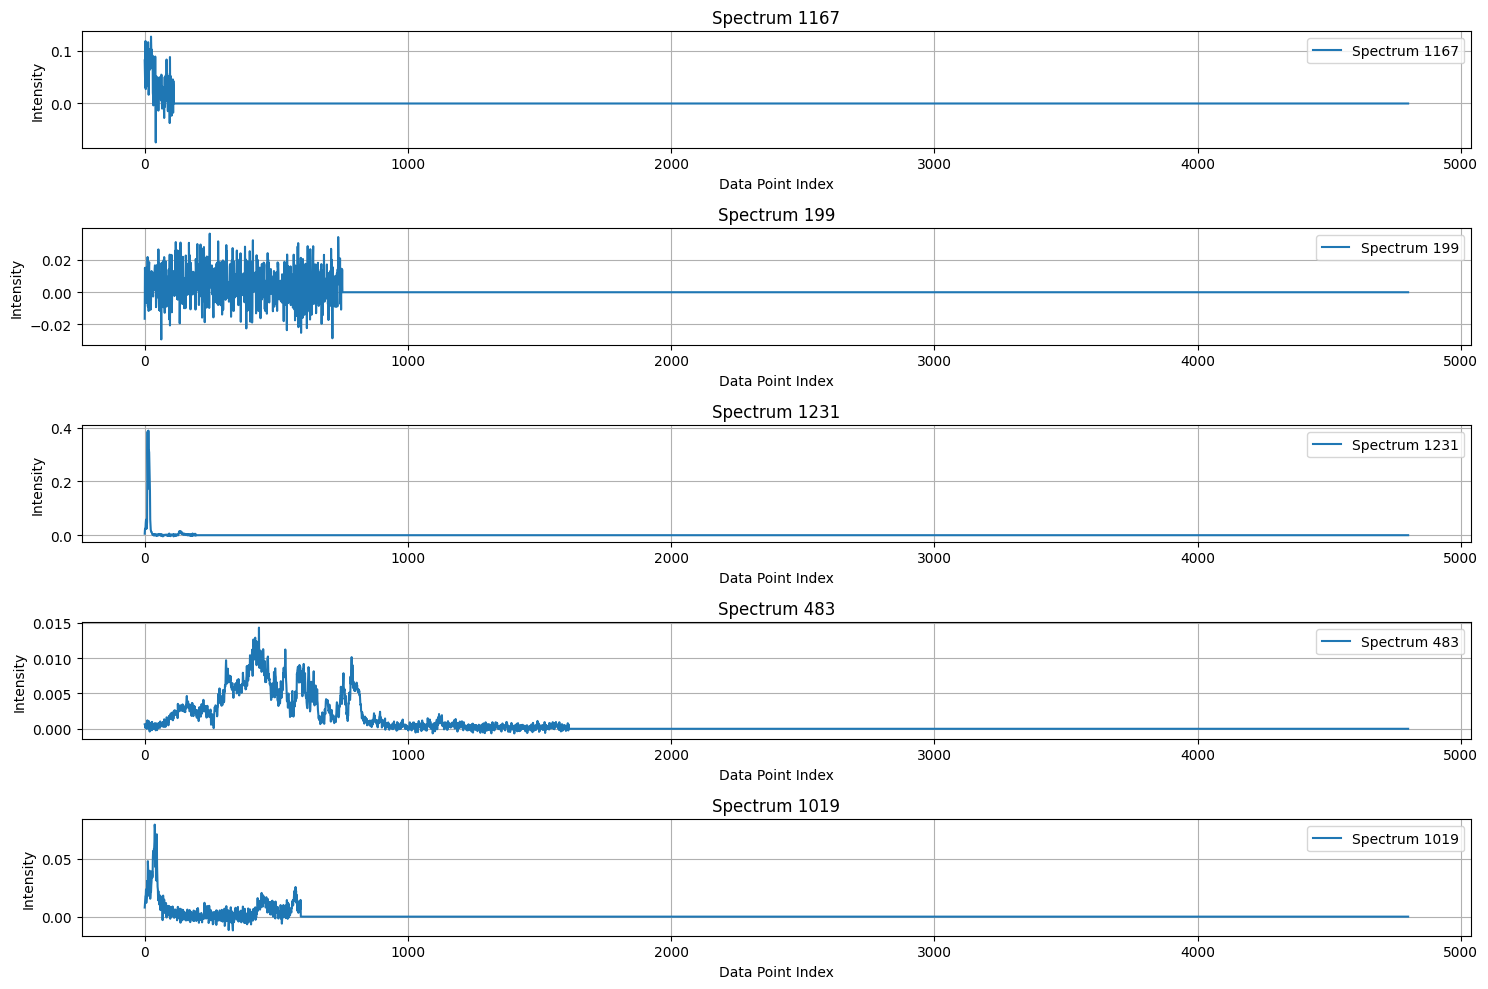

In [25]:
# Generate random indices
num_plots = 5
random_indices = np.random.choice(features.shape[0], num_plots, replace=False)

# Create x-axis values for the spectrum (assuming linear spacing)
x = np.linspace(0, features.shape[1], features.shape[1])

# Set up the plot
plt.figure(figsize=(15, 10))  # Increased size for better visibility

for i, idx in enumerate(random_indices):
    plt.subplot(num_plots, 1, i+1)  # Create a subplot for each spectrum
    plt.plot(x, features[idx], label=f'Spectrum {idx}')
    plt.title(f'Spectrum {idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


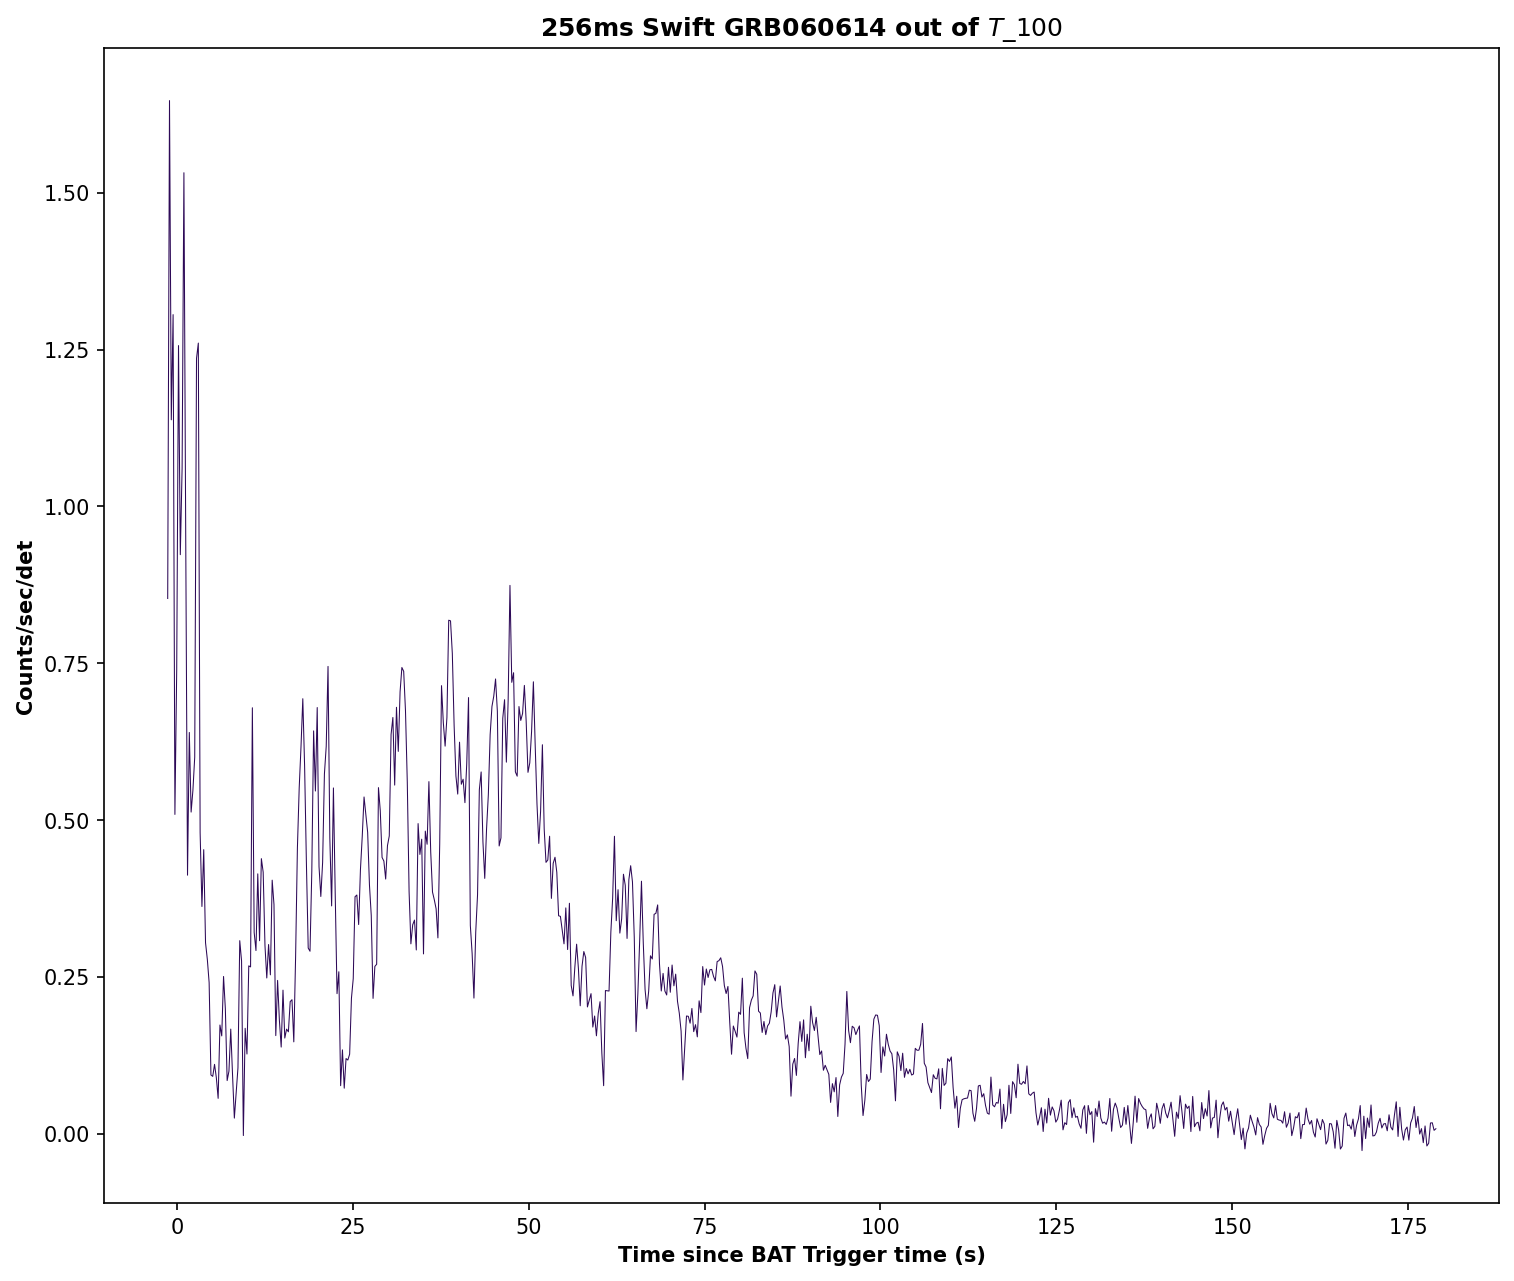

In [26]:
name = 'GRB060614'
ax2 = swift.plot_any_grb(name=name, legend=False, t=100,figsize=[12, 10], check_disk=True)

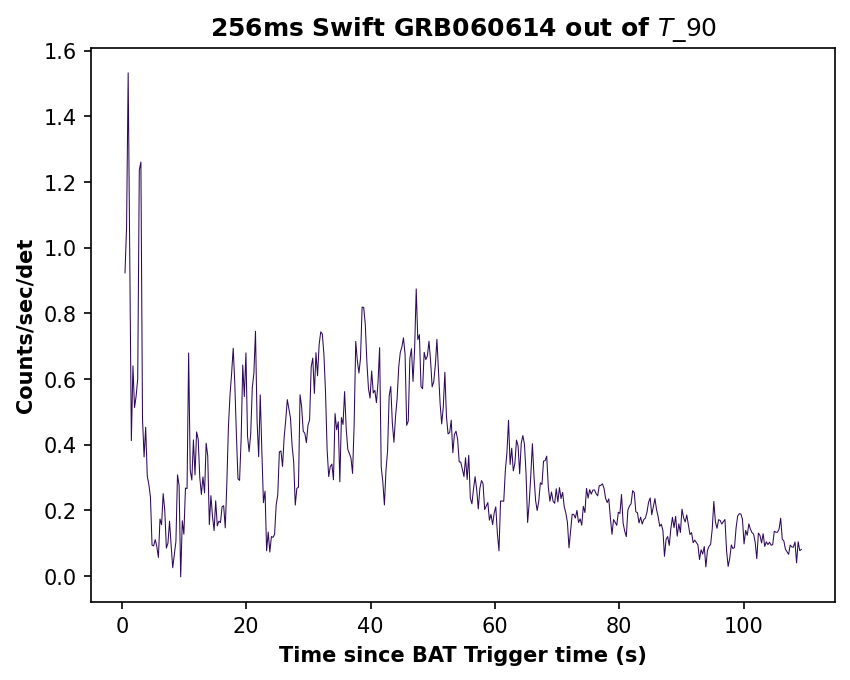

In [27]:
ax2 = swift.plot_any_grb(name=name,t=90, kind="concatenated", legend=False, check_disk=True)

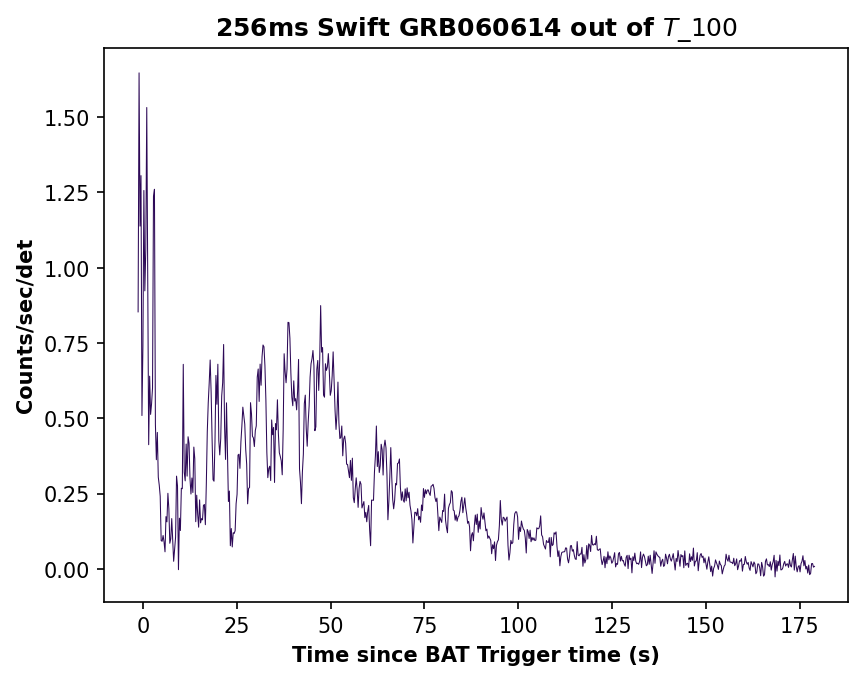

In [28]:
ax2 = swift.plot_any_grb(name=name,t=100, kind="concatenated", legend=False, check_disk=True)

In [32]:
# df2 = swift.noise_reduction_fabada(name='GRB060203', save_data=True)
# ax4 = swift.plot_any_grb(name='GRB060203', kind='Interpolated', legend=False, t=100)
# old_path = swift.original_data_path
# swift.original_data_path = swift.noise_data_path
# ax4 = swift.plot_any_grb(name='GRB060203', legend=True, ax=ax4, t=100, check_disk=True)
# swift.original_data_path = old_path

In [33]:
# cutoff until 2000
features = features[:,:2000]

In [34]:
features.shape

(1445, 2000)

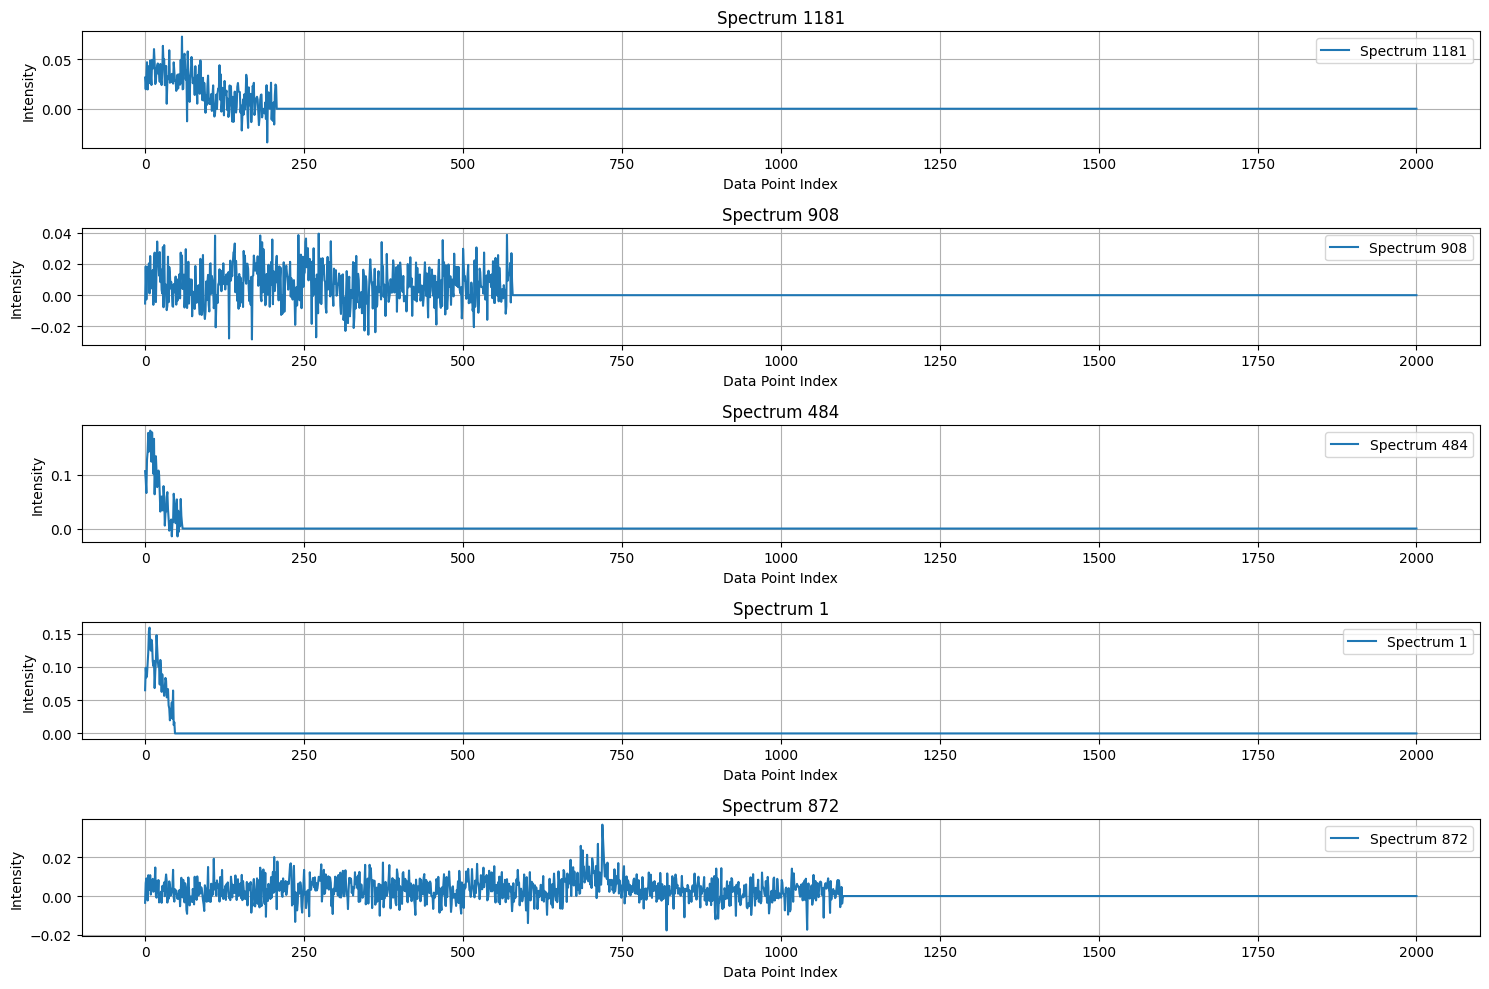

In [41]:
# Generate random indices
num_plots = 5
random_indices = np.random.choice(features.shape[0], num_plots, replace=False)

# Create x-axis values for the spectrum (assuming linear spacing)
x = np.linspace(0, features.shape[1], features.shape[1])

# Set up the plot
plt.figure(figsize=(15, 10))  # Increased size for better visibility

for i, idx in enumerate(random_indices):
    plt.subplot(num_plots, 1, i+1)  # Create a subplot for each spectrum
    plt.plot(x, features[idx], label=f'Spectrum {idx}')
    plt.title(f'Spectrum {idx}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [43]:
features_tensor = torch.tensor(features, dtype=torch.float)
features_tensor.shape

torch.Size([1445, 2000])

In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create a dataset
dataset = TensorDataset(features_tensor, features_tensor)  # inputs are also targets for an autoencoder

# Split the dataset into training and test sets
num_samples = len(dataset)
num_train = int(num_samples * 0.8)
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(dataset, [num_train, num_test])

# Define batch size
batch_size = 64

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# (Optional) Print some information to check
print(f"Total samples: {num_samples}, Training samples: {num_train}, Test samples: {num_test}")


Total samples: 1445, Training samples: 1156, Test samples: 289


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),  # Output: (16, 1000)
            nn.LeakyReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),  # Output: (32, 500)
            nn.LeakyReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # Output: (64, 250)
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),  # Output: (128, 125)
            nn.LeakyReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),  # Output: (256, 62)
            nn.LeakyReLU(),
            nn.Conv1d(256, 512, kernel_size=5, stride=2, padding=2),  # Output: (512, 31)
            nn.LeakyReLU(),
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),  # Output: (1024, 15)
            nn.LeakyReLU(),
            nn.Conv1d(1024, 1024, kernel_size=3, stride=2, padding=1),  # Output: (1024, 7)
            nn.LeakyReLU(),
            nn.Conv1d(1024, 1024, kernel_size=3, stride=7)  # Output: (1024, 1)
        )
        self.fc = nn.Linear(1024, 64)  # Flatten and connect to latent size

    def forward(self, x):
        x = x.unsqueeze(1)  # Ensure there's a channel dimension
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Compress to latent representation
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(64, 1024)  # Start with a fully connected layer
        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose1d(1024, 1024, kernel_size=3, stride=7),
            nn.ReLU(),
            nn.ConvTranspose1d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)  # Extend to suitable size for deconvolution
        x = x.view(x.size(0), 1024, 1)  # Reshape for transposed convolution
        x = self.conv_trans_layers(x)
        x = F.interpolate(x, size=2000)  # Resize to match original input size
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.squeeze(1)  # Remove channel dimension for output


In [56]:
# Initialize the Encoder
encoder = Encoder()
# Create a dummy input (batch size of 1 with 200 data points)
dummy_input = torch.randn(1, 2000)
# Get the encoded output
encoded_output = encoder(dummy_input)
print("Encoded output shape:", encoded_output.shape)


Encoded output shape: torch.Size([1, 64])


So latent size is 64.

(d) Now we can create the train/test loop that will help us calculate the objective function (MSE) and update the weights. We use Adam optimizer with learning rate 0.001.

In [57]:
import torch.optim as optim

# Initialize the autoencoder
autoencoder = Autoencoder()
if torch.cuda.is_available():
    autoencoder.cuda()  # Move model to GPU if available

# Define the loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [58]:
def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data  # Autoencoders don't need labels
            if torch.cuda.is_available():
                inputs = inputs.cuda()  # Move inputs to GPU

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')


In [59]:
def test_autoencoder(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # No gradient needed
        for data in test_loader:
            inputs, _ = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()  # Move inputs to GPU

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')


(e) Now let's put these into work and train the autoencoder, keeping track of the MSE

In [60]:
import matplotlib.pyplot as plt

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(test_loader.dataset)


In [61]:
num_epochs = 15
train_losses = []
test_losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_loss = train(autoencoder, train_loader, criterion, optimizer, device)
    test_loss = test(autoencoder, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/15, Train Loss: 0.0167, Test Loss: 0.0037
Epoch 2/15, Train Loss: 0.0015, Test Loss: 0.0005
Epoch 3/15, Train Loss: 0.0005, Test Loss: 0.0003
Epoch 4/15, Train Loss: 0.0004, Test Loss: 0.0003
Epoch 5/15, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 6/15, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 7/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 8/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 9/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 10/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 11/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 12/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 13/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 14/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 15/15, Train Loss: 0.0003, Test Loss: 0.0002


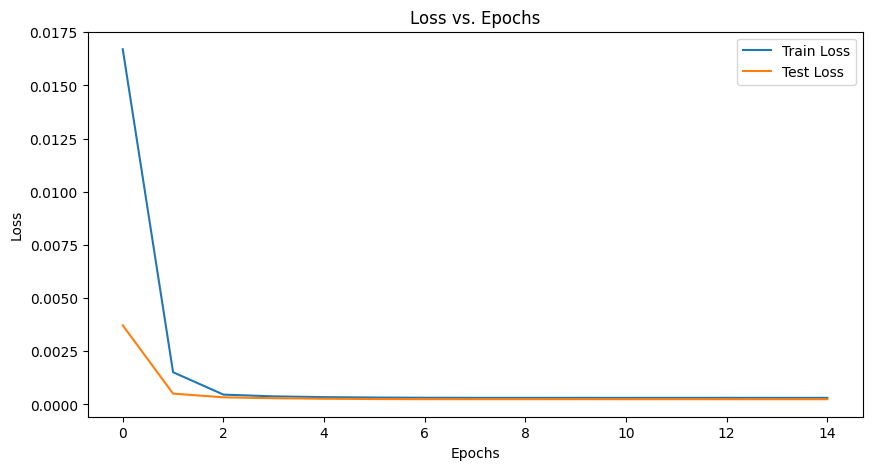

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(f) Let's see the actual reconstructed spectra

In [63]:
# Set the model to evaluation mode
autoencoder.eval()

# Randomly sample four indices from the test set
test_data_iter = iter(test_loader)
samples, _ = next(test_data_iter)
if torch.cuda.is_available():
    samples = samples.to('cuda')

with torch.no_grad():  # We don't need to track gradients here
    reconstructed = autoencoder(samples).cpu()  # Move data to CPU for plotting

# Assuming the test dataset and DataLoader are properly scaled and setup
samples = samples.cpu()  # Also move the original samples to CPU if not already


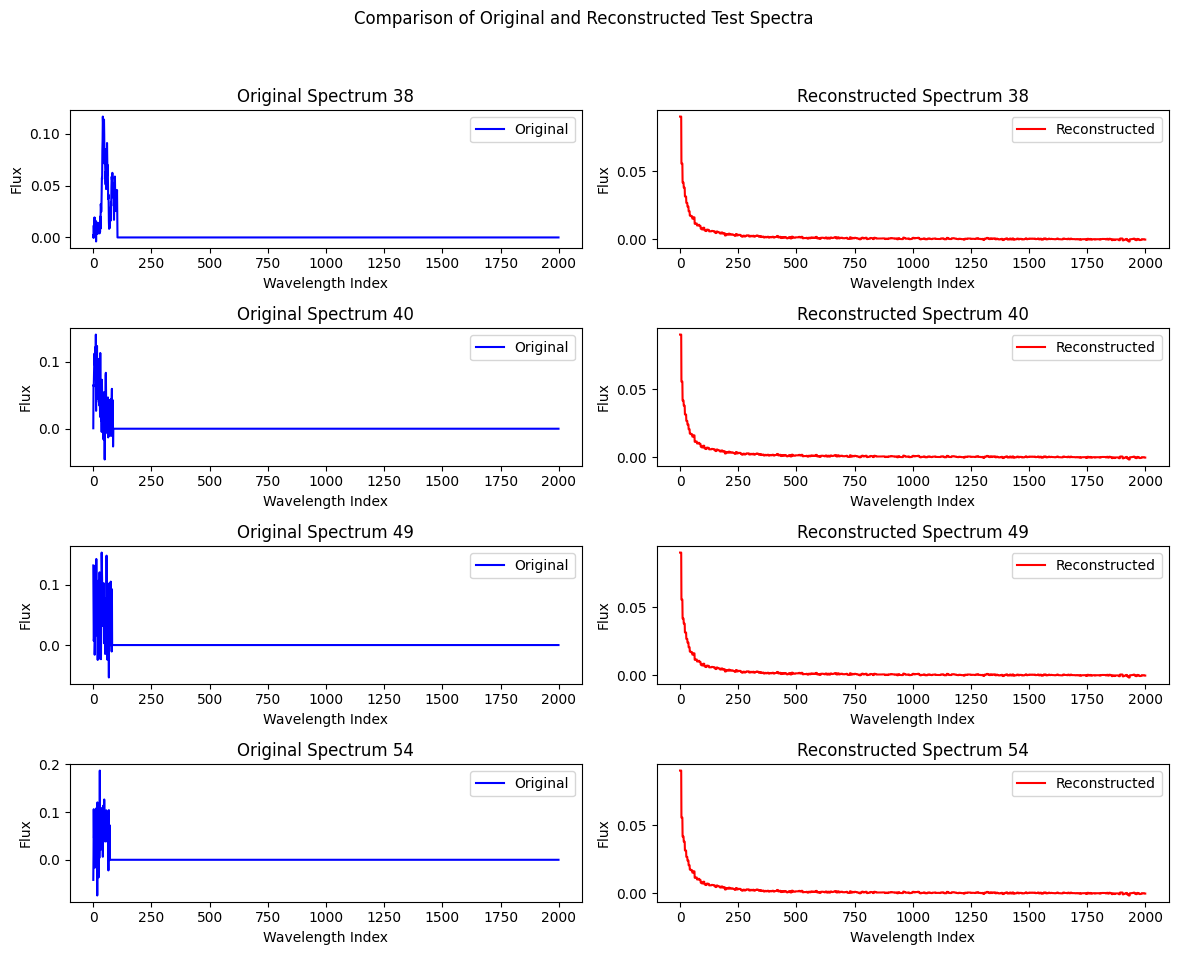

In [64]:
# Select four random test examples
indices = np.random.choice(len(samples), 4, replace=False)

# Create a plot
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
fig.suptitle('Comparison of Original and Reconstructed Test Spectra')

for i, idx in enumerate(indices):
    # Original spectra
    axs[i, 0].plot(samples[idx].numpy(), label='Original', color='b')
    axs[i, 0].set_title(f"Original Spectrum {idx+1}")
    axs[i, 0].set_xlabel('Wavelength Index')
    axs[i, 0].set_ylabel('Flux')
    axs[i, 0].legend()

    # Reconstructed spectra
    axs[i, 1].plot(reconstructed[idx].numpy(), label='Reconstructed', color='r')
    axs[i, 1].set_title(f"Reconstructed Spectrum {idx+1}")
    axs[i, 1].set_xlabel('Wavelength Index')
    axs[i, 1].set_ylabel('Flux')
    axs[i, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


The CNN manages to recreate the shape of flux of the overall continuum as well as some features like the broad peaks or troughs.

In [65]:
from torch.utils.data import DataLoader, TensorDataset


# Create dataset and dataloader
dataset = TensorDataset(features, torch.zeros(len(features)))  # Dummy targets, not used
data_loader = DataLoader(dataset, batch_size=256, shuffle=False)  # Adjust the batch size based on your system's capability

TypeError: 'int' object is not callable

In [ ]:
def encode_spectra(model, data_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    encoded_spectra = []

    with torch.no_grad():  # No need to calculate gradients
        for data, _ in data_loader:
            data = data.to(device)
            encoded_output = model.encoder(data)  # Encode
            encoded_spectra.append(encoded_output)

    # Concatenate all encoded outputs
    encoded_spectra = torch.cat(encoded_spectra, dim=0)
    return encoded_spectra

# Encode data
encoded_data = encode_spectra(autoencoder, data_loader, device)


In [ ]:
fname = f'autoencoded_cnn_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.pt'
torch.save(encoded_data, fname)